## Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import plotly

C:\Users\cleme\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
df=pd.read_json('ultimate_challenge/logins.json')

In [3]:
df.shape # 93,142 rows

(93142, 1)

In [4]:
df.head(5)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
df.isna().sum() # no nans

login_time    0
dtype: int64

In [6]:
df.login_time[0] # Timestamp object

Timestamp('1970-01-01 20:13:18')

In [7]:
df=df.groupby(pd.Grouper(key='login_time', freq="15Min")).size().reset_index() # groupby 15 minute intervals
df

,login_time,0
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1
...,...,...
9783,1970-04-13 17:45:00,5
9784,1970-04-13 18:00:00,5
9785,1970-04-13 18:15:00,2
9786,1970-04-13 18:30:00,7


In [8]:
df.sort_values(by=['login_time'], inplace=True) # sort by login_time

In [9]:
df.iloc[0] # earliest date January 1, 1970

login_time    1970-01-01 20:00:00
0                               2
Name: 0, dtype: object

In [10]:
df.iloc[-1] # latest date April 13, 1970

login_time    1970-04-13 18:45:00
0                               6
Name: 9787, dtype: object

In [11]:
date=df.login_time.iloc[0:192] # data from first 2 days
value=df[0].iloc[0:192]

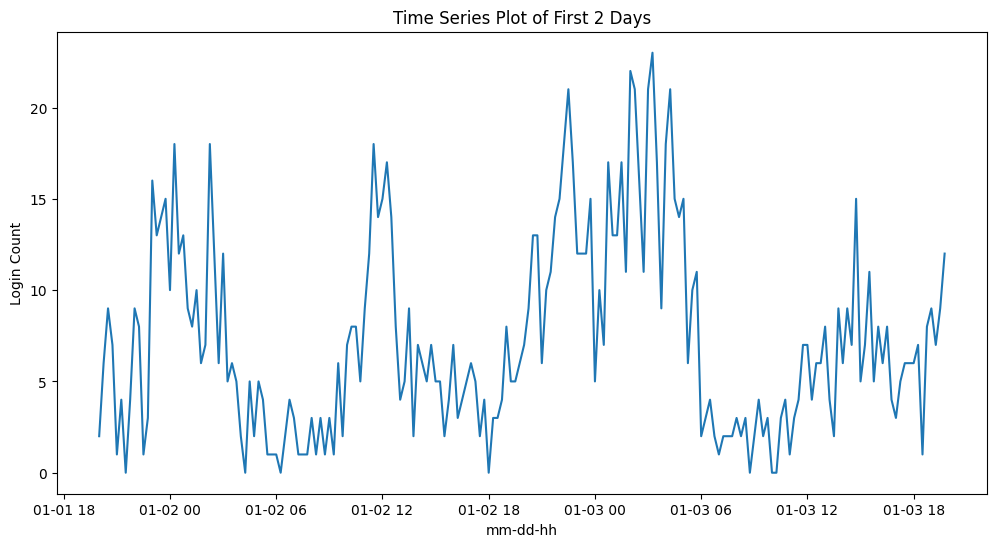

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.title('Time Series Plot of First 2 Days')
plt.xlabel('mm-dd-hh')
plt.ylabel('Login Count')
ax.plot(date, value);

## Periodic Trends and Forecasting

In [13]:
df.rename(columns={'login_time': 'ds', 0: 'y'}, inplace=True) # rename columns for prophet library
df.head(5) 

,ds,y
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


03:22:55 - cmdstanpy - INFO - Chain [1] start processing
03:22:55 - cmdstanpy - INFO - Chain [1] done processing


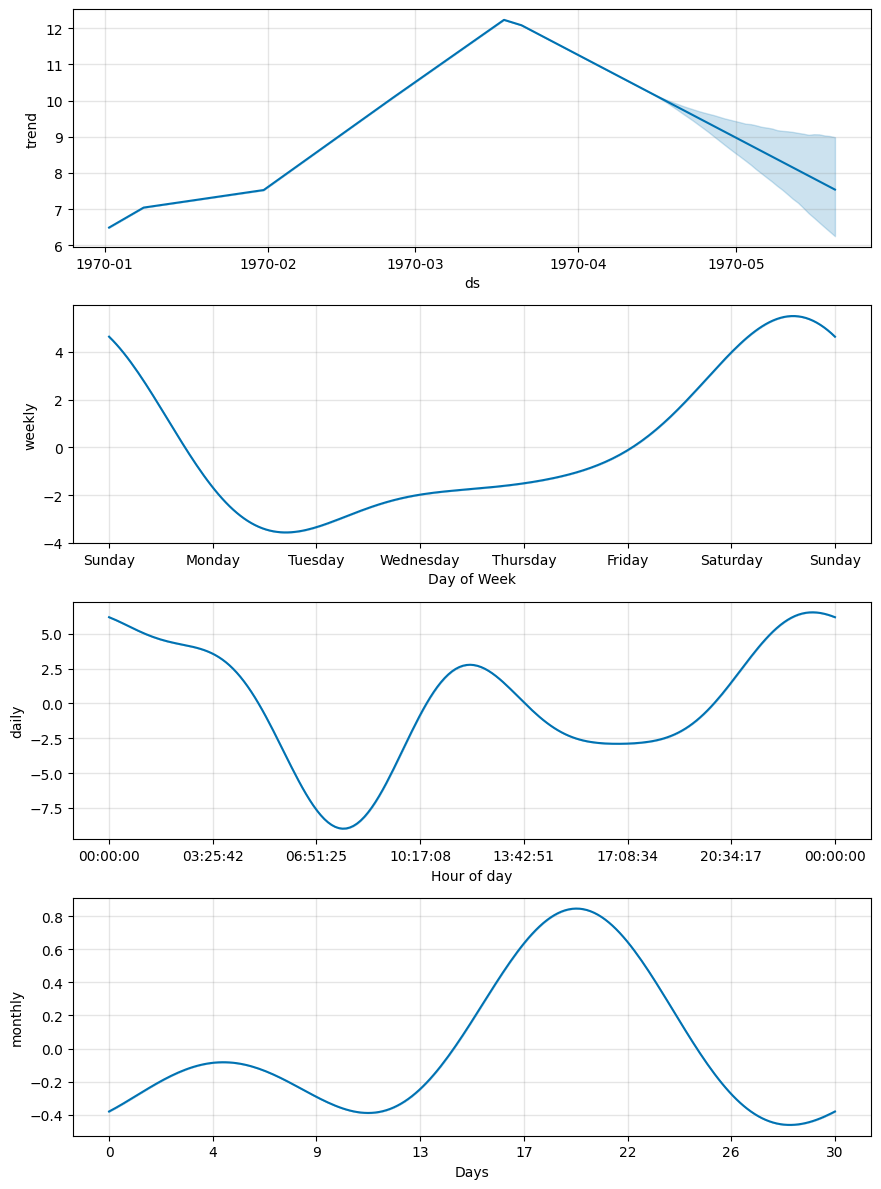

In [14]:
m = Prophet(yearly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=3)
m.fit(df)
future = m.make_future_dataframe(periods=36)
forecast = m.predict(future)
fig = m.plot_components(forecast)

We can see from the above graphs that there exists within the data cyclic patterns in the monthly, weekly, and daily periods. The linear combination of these cyclic patterns with the overall trend form a comprehensive time series analysis of the data.

**Monthly**

* There seem to be less logins during the first half of the month (-0.2) with logins then steadily increasing up (+0.8) until the 19th of the month and then steadily dropping back to the same rate as the first half of the month.

**Weekly**

* There is an obvious weekly trend with Mondays having the lowest number of logins (-4) with the number of logins slowly rising over the week peaking on the weekend (+5) and then rapidly decreasing as Monday approaches.

**Daily**

* The peak number of logins happen at midnight (+6) which drops during sleeping hours till around 7 in the morning (-7.5). It then rises to a local peak around noon (+2.5) then drops and plateaus until the end of the workday (-2.5) at 5 o'clock where it rises again till midnight.

**Overall Data Trend**

* The data spans 4.5 months from January 1, 1970 to April 13, 1970. At the start we see an average of 6.5 logins per day which steadily rises to over 12 logins a day at mid-march. From there, there is a steady decline of logins averaging 10 a day by mid April and continued projected downward number of logins.